In [1]:
import functools
import e3x
from flax import linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

# Disable future warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
jax.devices()

[cuda(id=0)]

# Moment of inertia tensor

In [28]:
def calculate_moment_of_inertia_tensor(masses, positions):
  diag = jnp.sum(positions**2, axis=-1)[..., None, None]*jnp.eye(3)
  outer = positions[..., None, :] * positions[..., :, None]
  return jnp.sum(masses[..., None, None] * (diag - outer), axis=-3)

def generate_datasets(key, num_train=1000, num_valid=100, num_points=10, min_mass=0.0, max_mass=1.0, stdev=1.0):
  # Generate random keys.
  train_position_key, train_masses_key, valid_position_key, valid_masses_key = jax.random.split(key, num=4)

  # Draw random point masses with random positions.
  train_positions = stdev * jax.random.normal(train_position_key,  shape=(num_train, num_points, 3))
  train_masses = jax.random.uniform(train_masses_key, shape=(num_train, num_points), minval=min_mass, maxval=max_mass)
  valid_positions = stdev * jax.random.normal(valid_position_key,  shape=(num_valid, num_points, 3))
  valid_masses = jax.random.uniform(valid_masses_key, shape=(num_valid, num_points), minval=min_mass, maxval=max_mass)

  # Calculate moment of inertia tensors.
  train_inertia_tensor = calculate_moment_of_inertia_tensor(train_masses, train_positions)
  valid_inertia_tensor = calculate_moment_of_inertia_tensor(valid_masses, valid_positions)

  # Return final train and validation datasets.
  train_data = dict(positions=train_positions, masses=train_masses, inertia_tensor=train_inertia_tensor)
  valid_data = dict(positions=valid_positions, masses=valid_masses, inertia_tensor=valid_inertia_tensor)
  return train_data, valid_data

In [29]:
class Model(nn.Module):
  features = 8
  max_degree = 1

  @nn.compact
  def __call__(self, masses, positions):  # Shapes (..., N) and (..., N, 3).
    # 1. Initialize features.
    x = jnp.concatenate((masses[..., None], positions), axis=-1) # Shape (..., N, 4).
    x = x[..., None, :, None]  # Shape (..., N, 1, 4, 1).

    # 2. Apply transformations.
    x = e3x.nn.Dense(features=self.features)(x)  # Shape (..., N, 1, 4, features).
    x = e3x.nn.TensorDense(max_degree=self.max_degree)(x)  # Shape (..., N, 2, (max_degree+1)**2, features).
    x = e3x.nn.TensorDense(  # Shape (..., N, 2, 9, 1).
        features=1,
        max_degree=2,
    )(x)
    # Try it: Zero-out irrep of degree 1 to only produce symmetric output tensors.
    # x = x.at[..., :, 1:4, :].set(0)

    # 3. Collect even irreps from feature channel 0 and sum over contributions from individual points.
    x = jnp.sum(x[..., 0, :, 0], axis=-2)  # Shape (..., (max_degree+1)**2).

    # 4. Convert output irreps to 3x3 matrix and return.
    cg = e3x.so3.clebsch_gordan(max_degree1=1, max_degree2=1, max_degree3=2)  # Shape (4, 4, 9).
    y = jnp.einsum('...l,nml->...nm', x, cg[1:, 1:, :])  # Shape (..., 3, 3).
    return y

In [30]:
def mean_squared_loss(prediction, target):
  return jnp.mean(optax.l2_loss(prediction, target))

In [31]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update'))
def train_step(model_apply, optimizer_update, batch, opt_state, params):
  def loss_fn(params):
    inertia_tensor = model_apply(params, batch['masses'], batch['positions'])
    loss = mean_squared_loss(inertia_tensor, batch['inertia_tensor'])
    return loss
  loss, grad = jax.value_and_grad(loss_fn)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

@functools.partial(jax.jit, static_argnames=('model_apply',))
def eval_step(model_apply, batch, params):
  inertia_tensor = model_apply(params, batch['masses'], batch['positions'])
  loss = mean_squared_loss(inertia_tensor, batch['inertia_tensor'])
  return loss

def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  params = model.init(init_key, train_data['masses'][0:1], train_data['positions'][0:1])
  opt_state = optimizer.init(params)

  # Determine the number of training steps per epoch.
  train_size = len(train_data['masses'])
  steps_per_epoch = train_size//batch_size

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Draw random permutations for fetching batches from the train data.
    key, shuffle_key = jax.random.split(key)
    perms = jax.random.permutation(shuffle_key, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
    perms = perms.reshape((steps_per_epoch, batch_size))

    # Loop over all batches.
    train_loss = 0.0  # For keeping a running average of the loss.
    for i, perm in enumerate(perms):
      batch = {k: v[perm, ...] for k, v in train_data.items()}
      params, opt_state, loss = train_step(
          model_apply=model.apply,
          optimizer_update=optimizer.update,
          batch=batch,
          opt_state=opt_state,
          params=params
      )
      train_loss += (loss - train_loss)/(i+1)

    # Evaluate on the test set after each training epoch.
    valid_loss = eval_step(
        model_apply=model.apply,
        batch=valid_data,
        params=params
    )

    # Print progress.
    print(f"epoch {epoch : 4d} train loss {train_loss : 8.6f} valid loss {valid_loss : 8.6f}")

  # Return final model parameters.
  return params

In [32]:
# Initialize PRNGKey for random number generation.
key = jax.random.PRNGKey(0)

# Generate train and test datasets.
key, data_key = jax.random.split(key)
train_data, valid_data = generate_datasets(data_key)

# Define training hyperparameters.
learning_rate = 0.002
num_epochs = 100
batch_size = 32

In [33]:
'''print(train_data['masses'][0:1].shape)
print(train_data['positions'][0:1].shape)'''

"print(train_data['masses'][0:1].shape)\nprint(train_data['positions'][0:1].shape)"

In [34]:
'''key, train_key = jax.random.split(key)
model = Model()
params = train_model(
  key=train_key,
  model=model,
  train_data=train_data,
  valid_data=valid_data,
  num_epochs=num_epochs,
  learning_rate=learning_rate,
  batch_size=batch_size,
)'''

'key, train_key = jax.random.split(key)\nmodel = Model()\nparams = train_model(\n  key=train_key,\n  model=model,\n  train_data=train_data,\n  valid_data=valid_data,\n  num_epochs=num_epochs,\n  learning_rate=learning_rate,\n  batch_size=batch_size,\n)'

In [35]:
'''i = 0
masses, positions, target = valid_data['masses'][i], valid_data['positions'][i], valid_data['inertia_tensor'][i]
prediction = model.apply(params, masses, positions)

print('target')
print(target)
print('prediction')
print(prediction)
print('mean squared error', jnp.mean((prediction-target)**2))'''

"i = 0\nmasses, positions, target = valid_data['masses'][i], valid_data['positions'][i], valid_data['inertia_tensor'][i]\nprediction = model.apply(params, masses, positions)\n\nprint('target')\nprint(target)\nprint('prediction')\nprint(prediction)\nprint('mean squared error', jnp.mean((prediction-target)**2))"

# Dataset 

In [383]:
filename = "Si16Vplus..DFT.SP-GRD.wB97X-D.tight.Data.2580.R_E_F_D_Q.npz"
dataset= np.load(filename)
for key in dataset.keys():
    print(key)
print('Dipole moment shape array',dataset['D'].shape)
print('Dipole moment units', dataset['D_units'])
#print('R units', dataset['R_units'])
print('Atomic numbers', dataset['z'])

type
R
z
E
F
F_units
e_unit
r_unit
name
theory
D
D_units
Q
README
F_min
F_max
F_mean
F_var
E_min
E_max
E_mean
E_var
md5
Dipole moment shape array (2580, 3)
Dipole moment units eAng
Atomic numbers [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# Dipole Moment

In [339]:
def prepare_datasets(filename, key, num_train, num_valid):
    # Load the dataset.
    dataset = np.load(filename)
    num_data = len(dataset["E"])

    Z = jnp.full(1, 23)
    Z = jnp.append(Z, jnp.full(16, 14))
    Z=jnp.expand_dims(Z,axis=0)
    Z=jnp.repeat(Z, num_data, axis=0)
    num_draw = num_train + num_valid
    if num_draw > num_data:
        raise RuntimeError(
            f"datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}"
        )

    # Randomly draw train and validation sets from dataset.
    choice = np.asarray(
        jax.random.choice(key, num_data, shape=(num_draw,), replace=False)
    )
    train_choice = choice[:num_train]
    valid_choice = choice[num_train:]

    # Collect and return train and validation sets.
    train_data = dict(
        #energy=jnp.asarray(dataset["E"][train_choice, 0] - mean_energy),
        #forces=jnp.asarray(dataset["F"][train_choice]),
        dipole_moment= jnp.asarray(dataset["D"][train_choice]),
        atomic_numbers=jnp.asarray(Z[train_choice]),
        # atomic_numbers=jnp.asarray(z_hack),
        positions=jnp.asarray(dataset["R"][train_choice]),
    )
    valid_data = dict(
        #energy=jnp.asarray(dataset["E"][valid_choice, 0] - mean_energy),
        #forces=jnp.asarray(dataset["F"][valid_choice]),
        atomic_numbers=jnp.asarray(Z[valid_choice]),
        dipole_moment= jnp.asarray(dataset["D"][valid_choice]),
        # atomic_numbers=jnp.asarray(z_hack),
        positions=jnp.asarray(dataset["R"][valid_choice]),
    )
    return train_data, valid_data

In [368]:
key = jax.random.PRNGKey(0)
num_train=2000
num_val=500
train_data,valid_data=prepare_datasets(filename,key, num_train,num_val)
print(train_data['dipole_moment'].shape)

(2000, 3)


In [341]:
class Dipole_Moment(nn.Module):
    # features = 1
    # max_degree = 1
    @nn.compact
    def __call__(self, atomic_numbers, positions):  # Shapes (..., N) and (..., N, 3).
        # 1. Initialize features
        """dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(17)
        print('dst_idx',dst_idx.shape)
        dst_idx = jnp.expand_dims(dst_idx, axis=0)
        src_idx = jnp.expand_dims(src_idx, axis=0)
        dst_idx = jnp.repeat(dst_idx, positions.shape[0], axis=0)
        src_idx = jnp.repeat(src_idx, positions.shape[0], axis=0)
        print('dst_idx after expansion',dst_idx.shape)
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst
        print('positions',positions.shape)
        print('displacements',displacements.shape)
        #x = e3x.nn.Embed(num_embeddings=self.max_atomic_number + 1, features=self.features)(atomic_numbers)
        Z= e3x.nn.Embed(num_embeddings=23, features=272)(atomic_numbers)
        print('atomic_numbers',atomic_numbers.shape)
        print('Z',Z.shape)
        Z=Z[0,...]
        Z=jnp.reshape(Z, (272, 17, 1))
        print('Z',Z.shape)
        x = jnp.concatenate((Z, displacements), axis=-1)"""

        positions -= positions[0, ...]

        x = jnp.concatenate(
            (atomic_numbers[..., None], positions), axis=-1
        )  # Shape (..., N, 4).
        # print("Initial shape:", x.shape)
        x = x[..., None, :, None]  # Shape (..., N, 1, 3, 1).
        # print("x shape:", x.shape)
        # 2. Apply transformations.
        x = e3x.nn.Dense(features=32)(x)
        # print("After Dense layer:", x.shape)
        x = e3x.nn.TensorDense(features=1, max_degree=1)(x)
        # print("After TensorDense layer:", x.shape)
        # x = e3x.nn.Dense(features=16)(x)
        # x = e3x.nn.Dense(features=1)(x)
        x = jnp.sum(x, axis=-4)
        # print("After sum:", x.shape)
        # x=jnp.sum(x, axis=0)
        # print("After second sum:", x.shape)
        y = x[..., 1, 1:4, 0]
        # y = x[1, 1:4, 0]
        # y=y[None,...]
        # print("After slicing:", y.shape)

        return y

In [342]:
class Dipole_Moment(nn.Module):
    # features = 1
    # max_degree = 1
    @nn.compact
    def __call__(self,atomic_numbers, positions):  # Shapes (..., N) and (..., N, 3).
        # 1. Initialize features
        positions -= positions[0, ...]
        x = jnp.concatenate(
            (atomic_numbers[..., None], positions), axis=-1
        )  # Shape (..., N, 4).
        # print("Initial shape:", x.shape)
        x = x[..., None, :, None]  # Shape (..., N, 1, 3, 1).

        # print("x shape:", x.shape)

        x = e3x.nn.Dense(features=512)(x)
        x = nn.relu(x)


        # Layer Normalization
        x = nn.LayerNorm()(x)

        x = e3x.nn.Dense(features=256)(x)
        x = nn.relu(x)


        # Layer Normalization
        x = nn.LayerNorm()(x)
        # Second Dense block

        x = e3x.nn.Dense(features=128)(x)
        x = nn.relu(x)


        # Layer Normalization
        x = nn.LayerNorm()(x)

        # Adding more complexity with TensorDense and additional layers
        x = e3x.nn.TensorDense(features=64, max_degree=2)(x)
        x = nn.relu(x)
        x = e3x.nn.TensorDense(features=32, max_degree=2)(x)
        x = nn.relu(x)

        x = e3x.nn.TensorDense(features=1, max_degree=1)(x)
        x = jnp.sum(x, axis=-4)
        y = x[..., 1, 1:4, 0]


        return y

In [369]:
class Dipole_Moment(nn.Module):
    # features = 1
    # max_degree = 1
    @nn.compact
    def __call__(self, atomic_numbers, positions):  # Shapes (..., N) and (..., N, 3).
        # 1. Initialize features
        #positions -= positions[0, ...]
        positions = positions - positions[:, 0:1, :]
        x = jnp.concatenate(
            (atomic_numbers[..., None], positions), axis=-1
        )  # Shape (..., N, 4).
        x = x[..., None, :, None]  # Shape (..., N, 1, 3, 1).

        # Incremento de complejidad con más capas densas
        x = e3x.nn.Dense(features=1024)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.Dense(features=512)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.Dense(features=256)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        # Más capas densas
        x = e3x.nn.Dense(features=128)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        # Capas TensorDense adicionales para más complejidad
        x = e3x.nn.TensorDense(features=64, max_degree=2)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.TensorDense(features=32, max_degree=2)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.TensorDense(features=16, max_degree=2)(x)
        x = e3x.nn.relu(x)
        x = nn.LayerNorm()(x)

        # Capa final
        x = e3x.nn.TensorDense(features=1, max_degree=1)(x)
        x = jnp.sum(x, axis=-4)
        y = x[..., 1, 1:4, 0]

        return y

In [42]:
class Dipole_Moment(nn.Module):
    # features = 1
    # max_degree = 1
    @nn.compact
    def __call__(self, atomic_numbers, positions):  # Shapes (..., N) and (..., N, 3).
        # 1. Initialize features
        positions -= positions[0, ...]
        x = jnp.concatenate(
            (atomic_numbers[..., None], positions), axis=-1
        )  # Shape (..., N, 4).
        x = x[..., None, :, None]  # Shape (..., N, 1, 3, 1).

        # Añadir bloque Transformer para relaciones más profundas
        x = nn.DenseGeneral(features=(512,), axis=-1)(x)
        x = nn.MultiHeadDotProductAttention(num_heads=8)(x, x)
        x = nn.LayerNorm()(x)
        x = nn.DenseGeneral(features=(256,), axis=-1)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        # Capas Dense adicionales
        x = e3x.nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        # Capas TensorDense adicionales para más complejidad
        x = e3x.nn.TensorDense(features=64, max_degree=1)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.TensorDense(features=32, max_degree=1)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        x = e3x.nn.TensorDense(features=16, max_degree=1)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)

        # Capa final
        x = e3x.nn.TensorDense(features=1, max_degree=1)(x)
        x = jnp.sum(x, axis=-4)
        y = x[..., 1, 1:4, 0]

        return y

In [43]:
'''dm_model = Dipole_Moment()
key = jax.random.PRNGKey(0)

# Generate train and test datasets.
key, data_key = jax.random.split(key)
train_data, valid_data = generate_datasets(data_key)
params = dm_model.init(key, train_data['atomic_numbers'][0:1], train_data['positions'][0:1])
moment=dm_model.apply(params,train_data['atomic_numbers'][0:1], train_data['positions'][0:1])
print(moment.shape)'''

"dm_model = Dipole_Moment()\nkey = jax.random.PRNGKey(0)\n\n# Generate train and test datasets.\nkey, data_key = jax.random.split(key)\ntrain_data, valid_data = generate_datasets(data_key)\nparams = dm_model.init(key, train_data['atomic_numbers'][0:1], train_data['positions'][0:1])\nmoment=dm_model.apply(params,train_data['atomic_numbers'][0:1], train_data['positions'][0:1])\nprint(moment.shape)"

In [44]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update'))
def train_step(model_apply, optimizer_update, batch, opt_state, params):

    def loss_fn(params):
        print(batch["positions"].shape)
        dipole_moment = model_apply(params, batch["atomic_numbers"], batch["positions"])
        loss = mean_squared_loss(dipole_moment, batch["dipole_moment"])
        return loss

    loss, grad = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

@functools.partial(jax.jit, static_argnames=('model_apply',))
def eval_step(model_apply, batch, params):
  dipole_moment = model_apply(params,batch['atomic_numbers'],batch['positions'])
  loss = mean_squared_loss(dipole_moment, batch['dipole_moment'])
  return loss


def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size):
    # Initialize model parameters and optimizer state.
    key, init_key = jax.random.split(key)
    optimizer = optax.adam(learning_rate)
    params = model.init(init_key, train_data['atomic_numbers'][0:1], train_data['positions'][0:1])
    opt_state = optimizer.init(params)
    
    # Initialize variables for tracking the best model and loss
    best_params = None
    best_valid_loss = float('inf')
    
    # Determine the number of training steps per epoch.
    train_size = len(train_data['positions'])
    steps_per_epoch = train_size // batch_size
    
    # Train for 'num_epochs' epochs.
    list_train_loss = []
    list_val_loss = []
    
    for epoch in range(1, num_epochs + 1):
        # Draw random permutations for fetching batches from the train data.
        key, shuffle_key = jax.random.split(key)
        perms = jax.random.permutation(shuffle_key, train_size)
        perms = perms[:steps_per_epoch * batch_size]  # Skip the last batch (if incomplete).
        perms = perms.reshape((steps_per_epoch, batch_size))
        
        # Loop over all batches.
        train_loss = 0.0  # For keeping a running average of the loss.
        
        for i, perm in enumerate(perms):
            batch = {k: v[perm, ...] for k, v in train_data.items()}
            
            params, opt_state, loss = train_step(
                model_apply=model.apply,
                optimizer_update=optimizer.update,
                batch=batch,
                opt_state=opt_state,
                params=params
            )
            train_loss += (loss - train_loss) / (i + 1)
        
        # Evaluate on the validation set after each training epoch.
        valid_loss = eval_step(
            model_apply=model.apply,
            batch=valid_data,
            params=params
        )
        list_val_loss.append(valid_loss)
        list_train_loss.append(train_loss)
        
        # Check if the current validation loss is the best we've seen so far.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_params = params
        
        # Print progress.
        print(f"epoch {epoch:4d} train loss {train_loss:8.6f} valid loss {valid_loss:8.6f}")
    
    # Return the best model parameters and the lists of train and validation losses.
    return best_params, list_train_loss, list_val_loss

In [385]:
# Initialize PRNGKey for random number generation.
key = jax.random.PRNGKey(0)
num_train=2000
num_val=500
train_data, valid_data = prepare_datasets(filename,key, num_train,num_val)

# Define training hyperparameters.
learning_rate = 0.001
num_epochs = 2000
batch_size = 512
key, train_key = jax.random.split(key)

In [372]:

model = Dipole_Moment()
params, list_train_loss, list_val_loss = train_model(
    key=train_key,
    model=model,
    train_data=train_data,
    valid_data=valid_data,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
)

(512, 17, 3)
epoch    1 train loss 6.460361 valid loss 13.729761
epoch    2 train loss 19.997490 valid loss 4.872768
epoch    3 train loss 8.838713 valid loss 11.893063
epoch    4 train loss 8.943563 valid loss 11.990310
epoch    5 train loss 7.855114 valid loss 9.153582
epoch    6 train loss 22.836384 valid loss 10.301203
epoch    7 train loss 9.614491 valid loss 10.841181
epoch    8 train loss 9.858075 valid loss 44.769146
epoch    9 train loss 19.239082 valid loss 5.107082
epoch   10 train loss 8.340735 valid loss 5.596352
epoch   11 train loss 4.511841 valid loss 2.455589
epoch   12 train loss 7.290314 valid loss 9.737181
epoch   13 train loss 7.296909 valid loss 3.426876
epoch   14 train loss 4.550248 valid loss 8.417161
epoch   15 train loss 5.250689 valid loss 3.791478
epoch   16 train loss 3.263251 valid loss 3.767081
epoch   17 train loss 3.987390 valid loss 5.382708
epoch   18 train loss 3.394279 valid loss 2.151001
epoch   19 train loss 2.034329 valid loss 4.759785
epoch   2

In [132]:
import pickle
model_save_path = (
    "mode_training_Si16Vplus..DFT.SP-GRD.wB97X-D.tight.Data.5042.R_E_F_D_Q.pkl"
)
with open(model_save_path, "wb") as f:
    pickle.dump(params, f)

In [387]:
Z, positions, target_all = (
    valid_data["atomic_numbers"],
    valid_data["positions"],
    valid_data["dipole_moment"],
)
#positions -= positions[0, ...]
#positions = positions - positions[:, 0:1, :]
prediction_all = model.apply(params, Z, positions)

In [ ]:
from math import acos, degrees
import numpy as np
from numpy import linalg as la


def angle_between(a, b):

    theta_degrees = degrees(acos((np.dot(a, b)) / (la.norm(a) * la.norm(b))))
    return theta_degrees


total = 0
list_angle = []
for i in range(len((prediction_all))):
    v = prediction_all[i]
    u = target_all[i]
    angle_degrees = angle_between(v, u)
    list_angle.append(angle_degrees)
    total += angle_degrees**2

print(np.sqrt(total / len(prediction_all)))

In [ ]:
plt.hist(
    list_angle,
    bins=40,
    edgecolor="black",
)

# Etiquetas y título
plt.xlabel("Ángulo (°)")
plt.ylabel("Densidad de Frecuencia")
plt.title("Histograma de la Distribución de Ángulos")

# Mostrar el gráfico
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_sq

def calcular_magnitud(vector):

    vector = np.array(vector)
    magnitud = np.linalg.norm(vector)
    return magnitud


total = 0
targets_mag = []
predictions_mag = []

for i in range(len((prediction_all))):
    v = prediction_all[i]
    u = target_all[i]
    mag_u = calcular_magnitud(u)
    mag_v = calcular_magnitud(v)
    diff = mag_u - mag_v
    total += diff

    targets_mag.append(mag_u)
    predictions_mag.append(mag_v)

print(np.abs(total / len(prediction_all)))
print(
    "mean_absolute_error magnitud:", mean_absolute_error(targets_mag, predictions_mag)
)
print(
    "mean squared error magnitud",
    jnp.mean((np.array(predictions_mag) - np.array(targets_mag)) ** 2),
)
print("RMSE magnitud ", root_mean_squared_error(targets_mag, predictions_mag))

0.04944158
0.024755895
0.003927753
0.19397697


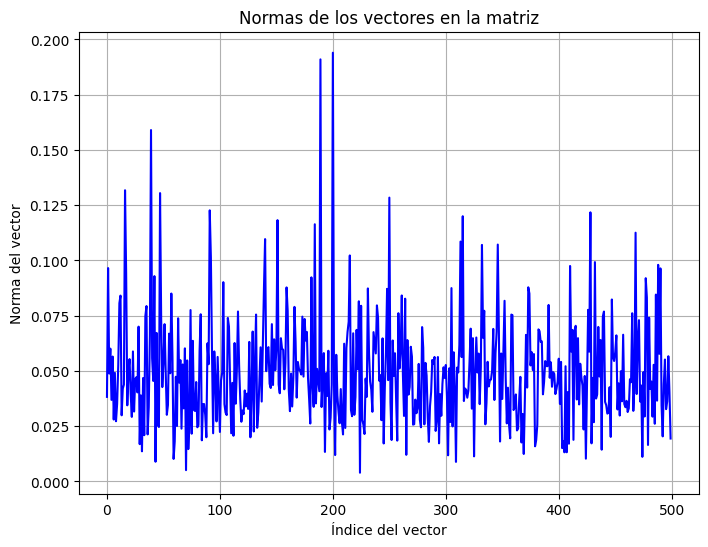

In [388]:
import matplotlib.pyplot as plt

normas = np.linalg.norm(prediction_all, axis=1)
#normas = normas[400:600]
# Graficar las normas
plt.figure(figsize=(8, 6))
plt.plot(range(len(normas)), normas, color="b")

# Etiquetas y título
plt.xlabel("Índice del vector")
plt.ylabel("Norma del vector")
plt.title("Normas de los vectores en la matriz")
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [393]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

print("std predict :", np.std(prediction_all))
print("std target  :", np.std(target_all))
print("mean_absolute_error :", mean_absolute_error(target_all, prediction_all))
print("mean squared error", jnp.mean((prediction_all - target_all) ** 2))
print("RMSE ", root_mean_squared_error(target_all, prediction_all))

std predict : 0.031521846
std target  : 0.10553296
mean_absolute_error : 0.08224416
mean squared error 0.011213878
RMSE  0.10589421


In [291]:
# huziel
filename = "/home/beemoqc2/Documents/e3x_tranfer/docs/source/examples/datoshuz.npz"
dataset = np.load(filename, allow_pickle=True)
for key in dataset.keys():
    print(key)

print("R", dataset["R"].shape)
# Modificar el array "R"
dataset_modified = {
    key: np.squeeze(value, axis=0) if key == "R" else value
    for key, value in dataset.items()
}

# Guardar el dataset modificado
np.savez(
    "/home/beemoqc2/Documents/e3x_tranfer/SI16VPLUS.E3X.RETRAINED.WB97X-D.TIGHT.TRP.100K.1B.01.POSITION_0_reshape.npz",
    **dataset_modified,
    allow_pickle=False,
)

R
typ
InLine_txt
name_original
bead
number_beads
theory_level
SuperCell
R (1, 200000, 17, 3)


In [376]:
import jax
import jax.numpy as jnp
import numpy as np


def prepare_datasets_test(filename, key, num_train, num_valid, batch_size):
    # Load the dataset.
    dataset = np.load(filename)
    num_data = len(dataset["R"])

    Z = jnp.full(1, 23)
    Z = jnp.append(Z, jnp.full(16, 14))
    Z = jnp.expand_dims(Z, axis=0)
    Z = jnp.repeat(Z, num_data, axis=0)
    num_draw = num_train + num_valid
    if num_draw > num_data:
        raise RuntimeError(
            f"datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}"
        )

    # Randomly draw train and validation sets from dataset.
    choice = np.asarray(
        jax.random.choice(key, num_data, shape=(num_draw,), replace=False)
    )
    train_choice = choice[:num_train]
    valid_choice = choice[num_train:]

    # Collect and return train and validation sets.
    train_data = dict(
        atomic_numbers=jnp.asarray(Z[train_choice]),
        positions=jnp.asarray(dataset["R"][train_choice]),
    )
    valid_data = dict(
        atomic_numbers=jnp.asarray(Z[valid_choice]),
        positions=jnp.asarray(dataset["R"][valid_choice]),
    )

    # Split the training data into batches
    train_batches = []
    #train_data["positions"] -= train_data["positions"][0, ...]
    for i in range(0, num_train, batch_size):
        batch_data = {
            "atomic_numbers": train_data["atomic_numbers"][i : i + batch_size],
            "positions": train_data["positions"][i : i + batch_size],
        }
        train_batches.append(batch_data)

    return train_batches, valid_data


num_train = 200000
num_val = 1
batch_size = 1024  # Ajusta este valor según la capacidad de tu memoria
filename = "/home/beemoqc2/Documents/e3x_tranfer/SI16VPLUS_E3X_RETRAINED_WB97X_D_TIGHT_TRP_400K_1B_01_POSITION_0_reshape.npz"
key = jax.random.PRNGKey(0)
train_batches, valid_data = prepare_datasets_test(
    filename, key, num_train, num_val, batch_size
)

i = 0
print(len(train_batches))
data_final = []
for batch in train_batches:
    i +=1
    print(i)
    Z, positions = (
        batch["atomic_numbers"],
        batch["positions"],
    )
    
    prediction = model.apply(params, Z, positions)
    data_final.append(prediction)

    # Aquí puedes continuar con el procesamiento o entrenamiento con `prediction`

196
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196


In [402]:
# Concatenar todos los arrays verticalmente
data_final_final = np.vstack(data_final)
print(data_final_final)
# Guardar el array combinado en un archivo .npz
np.savez(
    "/home/beemoqc2/Documents/e3x_tranfer/dipole_SI16VPLUS_E3X_RETRAINED_WB97X_D_TIGHT_TRP_400K_1B_01_POSITION_0_v2.npz",
    data=data_final_final,
)

[[-0.06705698 -0.04933084  0.00866679]
 [ 0.03873657  0.02406242  0.01783218]
 [ 0.04842487 -0.09198944  0.13651752]
 ...
 [ 0.04310646  0.01008602 -0.03125652]
 [ 0.0114958   0.03146298  0.01469914]
 [ 0.01103562  0.07003415  0.01485054]]


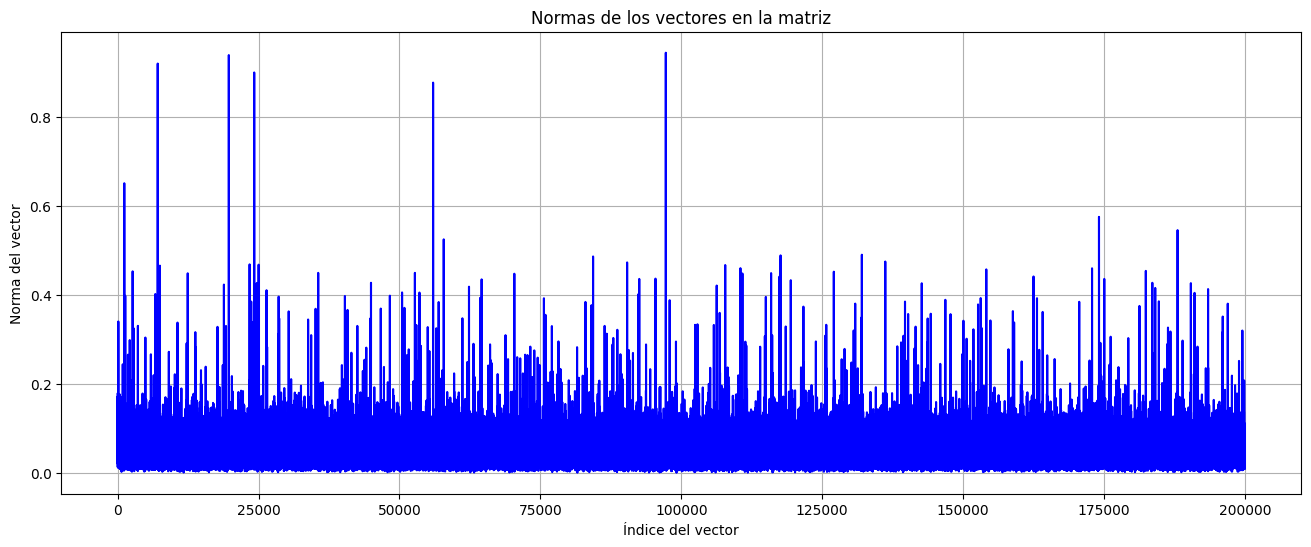

In [378]:
import matplotlib.pyplot as plt

normas = np.linalg.norm(data_final_final, axis=1)

# Graficar las normas
plt.figure(figsize=(16, 6))
plt.plot(range(len(normas)), normas, color="b")

# Etiquetas y título
plt.xlabel("Índice del vector")
plt.ylabel("Norma del vector")
plt.title("Normas de los vectores en la matriz")
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [379]:
test_data = "/home/beemoqc2/Documents/e3x_tranfer/dipole_SI16VPLUS_E3X_RETRAINED_WB97X_D_TIGHT_TRP_400K_1B_01_POSITION_0_v2.npz"
dataset_data = np.load(test_data)


In [ ]:
# another npz huziel
filename = "/home/beemoqc2/Documents/e3x_tranfer/SI16VPLUS_E3X_RETRAINED_WB97X_D_TIGHT_TRP_400K_1B_01_POSITION_0.npz"
dataset = np.load(filename)

In [104]:
import plotly.graph_objs as go
import plotly.io as pio
from typing import List

def create_loss_plot(
    train_loss: List[np.ndarray],
    val_loss: List[np.ndarray],
    train_label: str,
    val_label: str,
    title: str,
    filename: str,
) -> None:
    """
    Create a Plotly figure with training and validation loss curves and save it as an HTML file.

    Args:
        train_loss (List[np.ndarray]): List of training loss values.
        val_loss (List[np.ndarray]): List of validation loss values.
        train_label (str): Label for the training loss curve.
        val_label (str): Label for the validation loss curve.
        title (str): Title of the plot.
        filename (str): Filename to save the HTML file.

    Returns:
        None
    """
    train_loss_list = [float(loss) for loss in train_loss]
    val_loss_list = [float(loss) for loss in val_loss]

    trace_train = go.Scatter(y=train_loss_list, mode="lines", name=train_label)
    trace_val = go.Scatter(y=val_loss_list, mode="lines", name=val_label)

    fig = go.Figure()
    fig.add_trace(trace_train)
    fig.add_trace(trace_val)
    fig.update_layout(
        title=title, xaxis_title="Epoch", yaxis_title="Loss", legend_title="Legend"
    )
    pio.write_html(fig, filename)
    #fig.show()

create_loss_plot(
    list_train_loss,
    list_val_loss,
    "Training Loss",
    "Validation Loss",
    "Training vs Validation Loss (Train)",
    "train_vs_val_train_dipole_moment.html",
)

In [115]:
i = 45
Z, positions, target = valid_data['atomic_numbers'][i], valid_data['positions'][i], valid_data['dipole_moment'][i]
prediction = model.apply(params, Z, positions)

print('target')
print(target)
print('prediction')
print(prediction)
print('mean squared error', jnp.mean((prediction-target)**2))
print('positions \n', positions)

error_porcentual = abs(target - prediction) / abs(target) * 100
error_porcentual

In [400]:
i = 45
Z, positions, target = valid_data['atomic_numbers'][i], valid_data['positions'][i], valid_data['dipole_moment'][i]
# positions -= positions[0, ...]
#positions = positions - positions[0:1, :]
positions = np.expand_dims(positions, axis=0)
Z = np.expand_dims(Z, axis=0)
print(positions.shape)
print(Z.shape)
prediction = model.apply(params, Z, positions)

print('target')
print(target)
print('prediction')
print(prediction)
print('mean squared error', jnp.mean((prediction-target)**2))
# print('positions \n', positions)

(1, 17, 3)
(1, 17)
target
[ 0.174127   -0.10796383 -0.07853264]
prediction
[[-0.0212365  -0.03098422 -0.00646497]]
mean squared error 0.016428836


In [401]:
i = 45
Z, positions, target = valid_data['atomic_numbers'][i], valid_data['positions'][i], valid_data['dipole_moment'][i]
#positions = positions - positions[0:1, :]
positions = np.expand_dims(positions, axis=0)
Z = np.expand_dims(Z, axis=0)
print(positions.shape)
print(Z.shape)
positions+=jnp.array([0,0,1000])
#print(positions)
prediction = model.apply(params, Z, positions)

print('target')
print(target)
print('prediction')
print(prediction)
print('mean squared error', jnp.mean((prediction-target)**2))
# print('positions \n', positions)

(1, 17, 3)
(1, 17)
target
[ 0.174127   -0.10796383 -0.07853264]
prediction
[[-0.02008789 -0.03048658 -0.00758984]]
mean squared error 0.016251676


# MP Dipole Moment

In [ ]:
class MP_Dipole_Moment(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 118  # This is overkill for most applications.

    def dipole_moment(
        self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size
    ):
        # 1. Calculate displacement vectors.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff),
        )

        # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
        x = e3x.nn.Embed(
            num_embeddings=self.max_atomic_number + 1, features=self.features
        )(atomic_numbers)
        #print('Embed',x.shape)
        #print('Basis',basis.shape)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
                # features for efficiency reasons.
                y = e3x.nn.MessagePass(max_degree=2, include_pseudotensors=False)(
                    x, basis, dst_idx=dst_idx, src_idx=src_idx
                )
                #print('Final',y.shape)
                # After the final message pass, we can safely throw away all non-scalar features.
                x = e3x.nn.change_max_degree_or_type(
                    x, max_degree=2, include_pseudotensors=False
                )
            else:
                # In intermediate iterations, the message-pass should consider all possible coupling paths.
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
                #print('Message',y.shape)
            y = e3x.nn.add(x, y)

            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

            # Residual connection.
            x = e3x.nn.add(x, y)
            #print('Residual',x.shape)

        # 5. Predict atomic energies with an ordinary dense layer.
        #element_bias = self.param(
        #    "element_bias",
        #    lambda rng, shape: jnp.zeros(shape),
        #    (self.max_atomic_number + 1),
        #)
        x = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(x)  # (..., Natoms, 1, 9, 1)
        #print('After dense:',x.shape)
        x=jnp.sum(x, axis=-4) 
        #print("After sum:", x.shape)
        x = x[..., 1:4, 0]
        #print('After slicing:' ,x.shape)


        return x

    @nn.compact
    def __call__(
        self,
        atomic_numbers,
        positions,
        dst_idx,
        src_idx,
        batch_segments=None,
        batch_size=None,
    ):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        # Since we want to also predict forces, i.e. the gradient of the energy w.r.t. positions (argument 1), we use
        # jax.value_and_grad to create a function for predicting both energy and forces for us.
        
        dipole = self.dipole_moment(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

        return dipole

In [ ]:
dm_model = MP_Dipole_Moment()
key = jax.random.PRNGKey(0)

# Generate train and test datasets.
key, data_key = jax.random.split(key)
num_train=10
num_val=2
train_data,valid_data=prepare_datasets(filename,key, num_train,num_val)
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(17)
params = dm_model.init(key,
    atomic_numbers=train_data['atomic_numbers'][0],
    positions=train_data['positions'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
moment = dm_model.apply(
            params,
            atomic_numbers=train_data["atomic_numbers"][0],
            positions=train_data["positions"][0],
            dst_idx=dst_idx,
            src_idx=src_idx,
            batch_segments=None,
            batch_size=1,
        )
print(moment.shape)

Embed (17, 1, 1, 32)
Basis (272, 1, 9, 8)
Message (17, 1, 9, 32)
Residual (17, 1, 9, 32)
Message (17, 2, 9, 32)
Residual (17, 2, 9, 32)
Message (17, 2, 9, 32)
Residual (17, 2, 9, 32)
Final (17, 1, 9, 32)
Residual (17, 1, 9, 32)
After dense: (17, 1, 9, 1)
After sum: (1, 9, 1)
After slicing: (1, 3)
Embed (17, 1, 1, 32)
Basis (272, 1, 9, 8)
Message (17, 1, 9, 32)
Residual (17, 1, 9, 32)
Message (17, 2, 9, 32)
Residual (17, 2, 9, 32)
Message (17, 2, 9, 32)
Residual (17, 2, 9, 32)
Final (17, 1, 9, 32)
Residual (17, 1, 9, 32)
After dense: (17, 1, 9, 1)
After sum: (1, 9, 1)
After slicing: (1, 3)
(1, 3)


In [ ]:
def prepare_batches(key, data, batch_size):
    # Determine the number of training steps per epoch.
    data_size = len(data["dipole_moment"])
    steps_per_epoch = data_size // batch_size

    # Draw random permutations for fetching batches from the train data.
    perms = jax.random.permutation(key, data_size)
    perms = perms[
        : steps_per_epoch * batch_size
    ]  # Skip the last batch (if incomplete).
    perms = perms.reshape((steps_per_epoch, batch_size))

    # Prepare entries that are identical for each batch.
    num_atoms = len(data["atomic_numbers"])
    batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
    atomic_numbers = jnp.tile(data["atomic_numbers"], batch_size)
    offsets = jnp.arange(batch_size) * num_atoms
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)
    dst_idx = (dst_idx + offsets[:, None]).reshape(-1)
    src_idx = (src_idx + offsets[:, None]).reshape(-1)

    # Assemble and return batches.
    return [
        dict(
            dipole_moment=data["dipole_moment"][perm].reshape(-1, 3),
            atomic_numbers=atomic_numbers,
            positions=data["positions"][perm].reshape(-1, 3),
            dst_idx=dst_idx,
            src_idx=src_idx,
            batch_segments=batch_segments,
        )
        for perm in perms
    ]

In [ ]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, batch_size, opt_state, params):
  def loss_fn(params):
    dipole = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      dipole_prediction=dipole,
      dipole_target=batch['dipole_moment']
    )
    return loss
  loss, grad = jax.value_and_grad(loss_fn)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, params):
  dipole = model_apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
  )
  loss = mean_squared_loss(
    energy_prediction=dipole,
    energy_target=batch['dipole_moment']
  )
  return loss


def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, batch_size):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data['atomic_numbers']))
  params = model.init(init_key,
    atomic_numbers=train_data['atomic_numbers'],
    positions=train_data['positions'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
  opt_state = optimizer.init(params)

  # Batches for the validation set need to be prepared only once.
  key, shuffle_key = jax.random.split(key)
  valid_batches = prepare_batches(shuffle_key, valid_data, batch_size)

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Prepare batches.
    key, shuffle_key = jax.random.split(key)
    train_batches = prepare_batches(shuffle_key, train_data, batch_size)

    # Loop over train batches.
    train_loss = 0.0
    for i, batch in enumerate(train_batches):
      params, opt_state, loss= train_step(
        model_apply=model.apply,
        optimizer_update=optimizer.update,
        batch=batch,
        batch_size=batch_size,
        opt_state=opt_state,
        params=params
      )
      train_loss += (loss - train_loss)/(i+1)

    # Evaluate on validation set.
    valid_loss = 0.0
    for i, batch in enumerate(valid_batches):
      loss = eval_step(
        model_apply=model.apply,
        batch=batch,
        batch_size=batch_size,
        params=params
      )
      valid_loss += (loss - valid_loss)/(i+1)

    # Print progress.
    print(f"epoch: {epoch: 3d}                    train:   valid:")
    print(f"    loss [a.u.]             {train_loss : 8.3f} {valid_loss : 8.3f}")


  # Return final model parameters.
  return params